In [1]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib

In [2]:
# output_base_folder = Path("/iarai/work/logs/storage_benchmarking")
output_base_folder = Path("/home/ivan/temp/temp-benchmarking/")


# End to End benchmark
---
Storage performance test on S3 and Scratch with changing the size of the batch, number of workers, number of fetchers, and memory pinning.

**Experiment parameters**

| param | range |
| --- | --- |
| batch size | 16, 32, 64 | 
| num fetch workers |  4, 8, 16, 32 | 
| num workers |  0,  4,  8, 16 | 
| fetch_impl | asyncio, threaded |
| dataset | s3,scratch |
| pin memory | True, False | 

---

### TOC:
* [S3 Storage](#s3storage)
* [S3 Async vs Threaded Dataloader](#s3asynciovsthreaded)
* [Scratch Storage](#scratchstorage)
* [Scratch Async vs Threaded Dataloader](#scratchasynciovsthreaded)
* [S3 vs Scratch](#s3vsscratch)

**Parameters explained**

| param | implementation | details | 
| --- | --- | --- |
| batch size | asyncio | --- |
| | threaded | --- |
| num fetch workers | asyncio | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls. Also, the number of tasks initiall placed into the task (worker) queue. |
| | threaded | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls |
| num workers | asyncio | Number of workers that download batches in paralell (while batch items are usually fetched sequentially, here, they are fetched asynchronously) |
| | threaded | The same as for asyncio implementation, however, batch items are fetched with parallel threads and yealded. Once a batch is collected, it is yealded(1). |
| pin memory (2) | asyncio | Host (CPU) data allocations are pageable by default. The GPU cannot access data directly from pageable host memory, so when a data transfer from pageable host memory to device memory is invoked, the CUDA driver must first allocate a temporary page-locked, or “pinned”, host array, copy the host data to the pinned array, and then transfer the data from the pinned array to device memory. Pinned memory is used as a staging area for transfers from the device to the host. We can avoid the cost of the transfer between pageable and pinned host arrays by directly allocating our host arrays in pinned memory. |
| | threaded | Same as for asyncio |

(1) batch_pool_size - Number of batches to fetch in parallel (normally, one batch is fetched, and items are downloaded (sequentiall or in parallel). This implementation takes N batches, and starts downloading items in parallel. Individual items are yielded and once a full batch is collected it is yielded. Fixed to 10, as previous experiments show it doesn't have much influence. 

(2) https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

**In all plots, lower is better!**

Testing script:

```bash
for pin_memory in 0 1; do
  for fetch_impl in "threaded" "asyncio"; do
    for storage in "s3" "scratch"; do
      for batch_size in 16 32 64; do
        for num_workers in 0 4 8 16; do
          for num_fetch_workers in 4 8 16 32; do
            python3 train/imagenet.py --output_base_folder /iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output/e2e \
            --dataset "${storage}" \
            --num-fetch-workers "${num_fetch_workers}" \
            --num-workers "${num_workers}" \
            --dataset-limit 1024 \
            --batch-size "${batch_size}" \
            --prefetch-factor 2 \
            --fetch-impl "${fetch_impl}" \
            --pin-memory "${pin_memory}" \
            --accelerator dp
          done
        done
      done
    done
  done
done
```

## S3 Storage <a class="anchor" id="s3storage">

In [3]:
group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers", "batch_pool"]

In [4]:
df_dataloader_s3_full = extract_pandas(output_base_folder, folder_filter="latest/e2e/*benchmark_e2e_s3*")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15213/15213 [05:17<00:00, 47.97it/s]


In [5]:
df_dataloader_s3_async=df_dataloader_s3_full[df_dataloader_s3_full["fetch_impl"]=="asyncio"]
df_dataloader_s3_threaded=df_dataloader_s3_full[df_dataloader_s3_full["fetch_impl"]=="threaded"]
# save memory 
del df_dataloader_s3_full
# show record num
print(f"Records {len(df_dataloader_s3_async)}")
print(f"Records {len(df_dataloader_s3_threaded)}")

Records 1909162
Records 2173076


In [6]:
display(get_run_stats(df_dataloader_s3_async, group_by=group_by_dataloader))
display(get_run_stats(df_dataloader_s3_threaded, group_by=group_by_dataloader))

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                   
s3      4                 0           10         20211005f023817_benchmark_e2e_s3_16_0_4_sync           1.310854e+09   
                                                 20211005f035047_benchmark_e2e_s3_32_0_4_sync           1.314469e+09   
                                                 20211005f051147_benchmark_e2e_s3_64_0_4_sync           1.322931e+09   
                                                 20211005f120618_benchmark_e2e_s3_16_0_4_sync           1.310854e+09   
                                                 20211005f132102_benchmark_e2e_s3_32_0_4_sync           1.314469e+09   
...                                                                                                              ...   
        32                16          10         20211005f045528_benchmark_e2e_s3_32_16_32_sync         2.812828e+09   
                                                 20211005f061635_benchmark_e2e_s3_64_16_32_sync         2.887881e+09   
                                                 20211005f131232_benchmark_e2e_s3_16_16_32_sync         2.688887e+09   
                                                 20211005f142730_benchmark_e2e_s3_32_16_32_sync         2.829984e+09   
                                                 20211005f154723_benchmark_e2e_s3_64_16_32_sync         2.887881e+09   

                                                                                                   time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                            
s3      4                 0           10         20211005f023817_benchmark_e2e_s3_16_0_4_sync    1.633394e+09   
                                                 20211005f035047_benchmark_e2e_s3_32_0_4_sync    1.633399e+09   
                                                 20211005f051147_benchmark_e2e_s3_64_0_4_sync    1.633404e+09   
                                                 20211005f120618_benchmark_e2e_s3_16_0_4_sync    1.633428e+09   
                                                 20211005f132102_benchmark_e2e_s3_32_0_4_sync    1.633433e+09   
...                                                                                                       ...   
        32                16          10         20211005f045528_benchmark_e2e_s3_32_16_32_sync  1.633403e+09   
                                                 20211005f061635_benchmark_e2e_s3_64_16_32_sync  1.633407e+09   
                                                 20211005f131232_benchmark_e2e_s3_16_16_32_sync  1.633432e+09   
                                                 20211005f142730_benchmark_e2e_s3_32_16_32_sync  1.633437e+09   
                                                 20211005f154723_benchmark_e2e_s3_64_16_32_sync  1.633442e+09   

                                                                                                     time_end  \
dataset num_fetch_workers num_workers batch_pool run                                                            
s3      4                 0           10         20211005f023817_benchmark_e2e_s3_16_0_4_sync    1.633395e+09   
                                                 20211005f035047_benchmark_e2e_s3_32_0_4_sync    1.633399e+09   
                                                 20211005f051147_benchmark_e2e_s3_64_0_4_sync    1.633404e+09   
                                                 20211005f120618_benchmark_e2e_s3_16_0_4_sync    1.633429e+09   
                                                 20211005f132102_benchmark_e2e_s3_32_0_4_sync    1.633433e+09   
...                                                                                                       ...   
        32                16          10         20211005f045528_benchmark_e2e_s3_32_16_32_sync  1.633403e+09   
                                                 

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                   
s3      4                 0           10         20211004f215021_benchmark_e2e_s3_16_0_4_sync           2.220311e+09   
                                                 20211004f231202_benchmark_e2e_s3_32_0_4_sync           2.491588e+09   
                                                 20211005f003959_benchmark_e2e_s3_64_0_4_sync           2.339791e+09   
                                                 20211005f070943_benchmark_e2e_s3_16_0_4_sync           2.221882e+09   
                                                 20211005f084005_benchmark_e2e_s3_32_0_4_sync           2.493323e+09   
...                                                                                                              ...   
        32                16          10         20211005f002215_benchmark_e2e_s3_32_16_32_sync         2.599831e+09   
                                                 20211005f014526_benchmark_e2e_s3_64_16_32_sync         2.538207e+09   
                                                 20211005f082157_benchmark_e2e_s3_16_16_32_sync         2.456020e+09   
                                                 20211005f095000_benchmark_e2e_s3_32_16_32_sync         2.640500e+09   
                                                 20211005f111257_benchmark_e2e_s3_64_16_32_sync         2.538207e+09   

                                                                                                   time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                            
s3      4                 0           10         20211004f215021_benchmark_e2e_s3_16_0_4_sync    1.633377e+09   
                                                 20211004f231202_benchmark_e2e_s3_32_0_4_sync    1.633382e+09   
                                                 20211005f003959_benchmark_e2e_s3_64_0_4_sync    1.633387e+09   
                                                 20211005f070943_benchmark_e2e_s3_16_0_4_sync    1.633411e+09   
                                                 20211005f084005_benchmark_e2e_s3_32_0_4_sync    1.633416e+09   
...                                                                                                       ...   
        32                16          10         20211005f002215_benchmark_e2e_s3_32_16_32_sync  1.633386e+09   
                                                 20211005f014526_benchmark_e2e_s3_64_16_32_sync  1.633391e+09   
                                                 20211005f082157_benchmark_e2e_s3_16_16_32_sync  1.633415e+09   
                                                 20211005f095000_benchmark_e2e_s3_32_16_32_sync  1.633420e+09   
                                                 20211005f111257_benchmark_e2e_s3_64_16_32_sync  1.633425e+09   

                                                                                                     time_end  \
dataset num_fetch_workers num_workers batch_pool run                                                            
s3      4                 0           10         20211004f215021_benchmark_e2e_s3_16_0_4_sync    1.633377e+09   
                                                 20211004f231202_benchmark_e2e_s3_32_0_4_sync    1.633382e+09   
                                                 20211005f003959_benchmark_e2e_s3_64_0_4_sync    1.633388e+09   
                                                 20211005f070943_benchmark_e2e_s3_16_0_4_sync    1.633411e+09   
                                                 20211005f084005_benchmark_e2e_s3_32_0_4_sync    1.633416e+09   
...                                                                                                       ...   
        32                16          10         20211005f002215_benchmark_e2e_s3_32_16_32_sync  1.633387e+09   
                                                 

### Filter

In [7]:
print(np.unique(df_dataloader_s3_async["num_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_async["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_async["batch_size"].to_numpy()))

[ 0  4  8 16]
[ 4  8 16 32]
[16 32 64]


In [8]:
import seaborn as sns

def filter_data(df):
    data = pd.DataFrame()
    for num_workers in np.unique(df["num_workers"].to_numpy()):
        for num_fetch_workers in np.unique(df["num_fetch_workers"].to_numpy()):
            for batch_size in np.unique(df["batch_size"].to_numpy()):
                for pin_memory in np.unique(df["pin_memory"].to_numpy()):
                    df_temp=df[(df["num_workers"]==num_workers) &
                                                 (df["num_fetch_workers"]==num_fetch_workers) &
                                                 (df["batch_size"]==batch_size) &
                                                 (df["pin_memory"]==pin_memory)]
                    df_step_time = df_temp[df_temp["trace_name"]=="(6)-training_step"]
                    step_time_list_process_time = df_step_time["process_time"].to_numpy()
                    step_time_list_elapsed = df_step_time["elapsed"].to_numpy()

                    mean_step_time = np.mean(step_time_list_process_time)
                    median_step_time = np.median(step_time_list_process_time)
                    min_step_time = np.min(step_time_list_process_time)
                    max_step_time = np.max(step_time_list_process_time)
                    data = data.append(
                                        {"mean": mean_step_time, 
                                        "median": median_step_time,
                                        "pin_memory": pin_memory, 
                                        "num_workers": num_workers, 
                                        "num_fetch_workers": num_fetch_workers, 
                                        "batch_size": batch_size, 
                                        "config": f"{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}, ignore_index=True)
    return data


In [9]:
data_s3_async = filter_data(df_dataloader_s3_async)
data_s3_threaded = filter_data(df_dataloader_s3_threaded)
del df_dataloader_s3_async
del df_dataloader_s3_threaded

In [10]:
data_s3_async.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
76,0.003911,0.003526,0.0,16.0,4.0,64.0,"16, 4, 64, 0"
24,0.004182,0.003946,0.0,4.0,4.0,16.0,"4, 4, 16, 0"
78,0.004202,0.003993,0.0,16.0,8.0,16.0,"16, 8, 16, 0"
90,0.004204,0.003966,0.0,16.0,32.0,16.0,"16, 32, 16, 0"
84,0.004237,0.004031,0.0,16.0,16.0,16.0,"16, 16, 16, 0"
...,...,...,...,...,...,...,...
63,0.005749,0.004923,1.0,8.0,16.0,32.0,"8, 16, 32, 1"
89,0.005856,0.003963,1.0,16.0,16.0,64.0,"16, 16, 64, 1"
53,0.005868,0.003929,1.0,8.0,4.0,64.0,"8, 4, 64, 1"
59,0.006235,0.004749,1.0,8.0,8.0,64.0,"8, 8, 64, 1"


Considering end-to-end training, and only training step time average, memory_pinning set to False is better.
The best performing configuration is:
Asyncio:

{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}
**16 num_workers, 4 num_fetch_workers, 64 batch_size, 0 pin_memory**

In [11]:
data_s3_threaded.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
92,0.004009,0.003579,0.0,16.0,32.0,32.0,"16, 32, 32, 0"
94,0.004024,0.003688,0.0,16.0,32.0,64.0,"16, 32, 64, 0"
90,0.004048,0.003843,0.0,16.0,32.0,16.0,"16, 32, 16, 0"
54,0.004126,0.003890,0.0,8.0,8.0,16.0,"8, 8, 16, 0"
78,0.004132,0.003864,0.0,16.0,8.0,16.0,"16, 8, 16, 0"
...,...,...,...,...,...,...,...
41,0.005270,0.004502,1.0,4.0,16.0,64.0,"4, 16, 64, 1"
75,0.005354,0.004164,1.0,16.0,4.0,32.0,"16, 4, 32, 1"
53,0.005355,0.003880,1.0,8.0,4.0,64.0,"8, 4, 64, 1"
95,0.005588,0.003996,1.0,16.0,32.0,64.0,"16, 32, 64, 1"


Asyncio:

{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}"}
**16 num_workers, 32 num_fetch_workers, 32 batch_size, 0 pin_memory**

**Memory pinning** <a class="anchor" id="s3mempin">

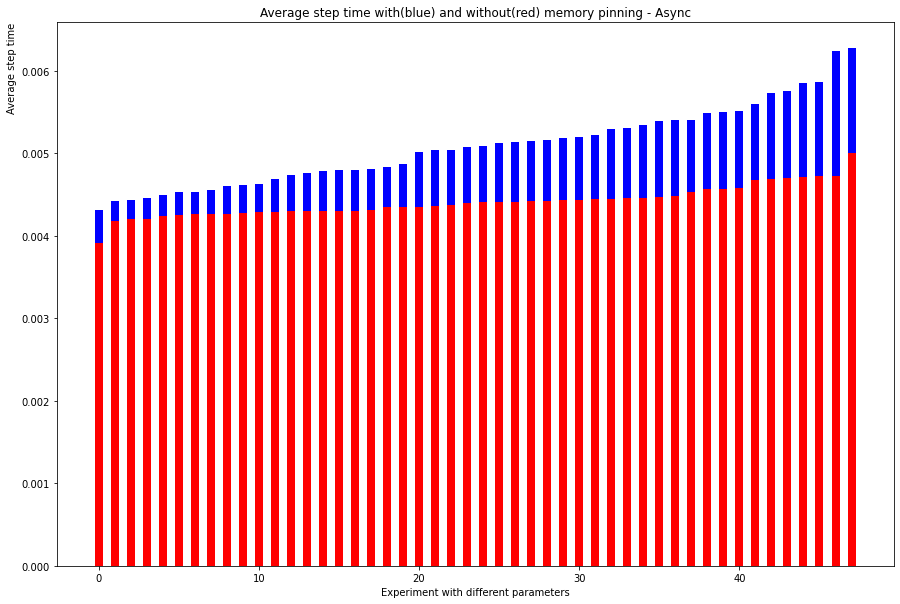

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_async[data_s3_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Async", loc='center')
del data

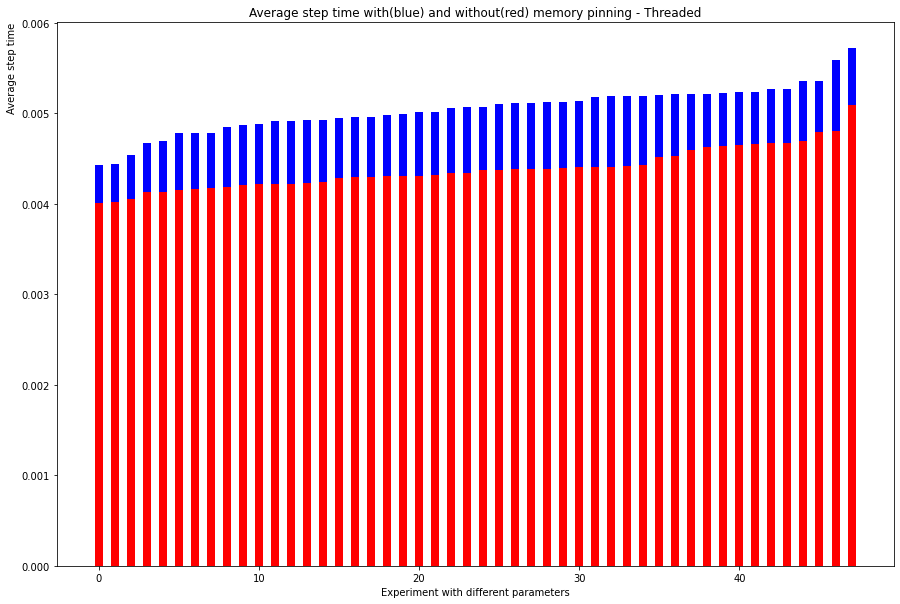

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_threaded[data_s3_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Threaded", loc='center')
del data

**S3: Threaded vs Asyncio without pinning memory** <a class="anchor" id="s3mempinboth">

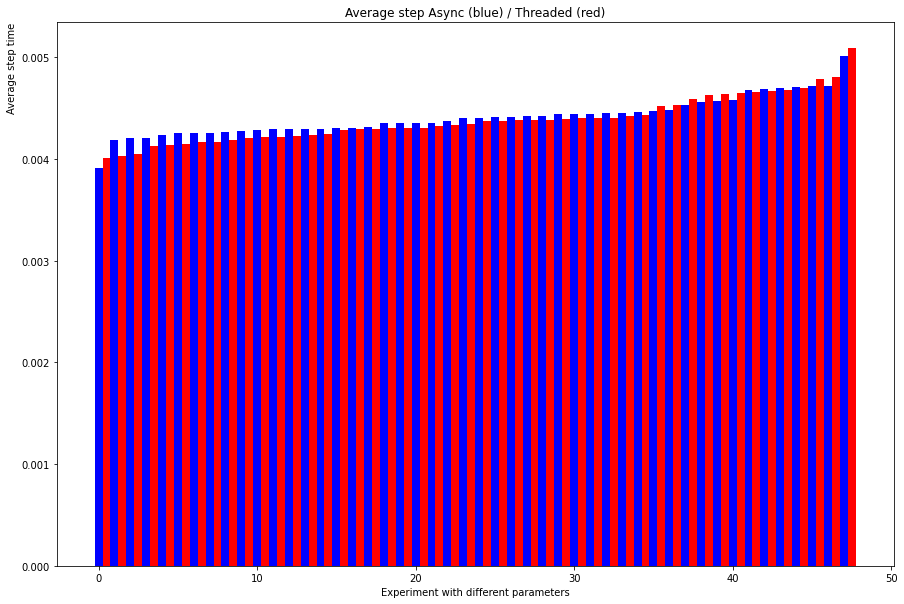

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.5 for x in range(len(data))], height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step Async (blue) / Threaded (red)", loc='center')
del data

Considering end to end implementation asyncio and threaded implementation seem to be comparable, though threaded seems to be slightly better in most cases. 

### Asyncio vs Threaded for S3 <a class="anchor" id="s3asynciovsthreaded">

In [15]:
from matplotlib.patches import Patch

num_workers_unique = np.unique(data_s3_async["num_workers"].to_numpy())
batch_size_unique = np.unique(data_s3_async["batch_size"].to_numpy())
num_fetch_workers_unique = np.unique(data_s3_async["num_fetch_workers"].to_numpy())


In [16]:
def plot_data(dataframe, fixed_param, fixed_value, changing_param, changing_values):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    colors = sns.color_palette(None, len(changing_values))
    param_colors = dict(zip(changing_values, colors))
    patches = [Patch(color=v, label=k) for k, v in param_colors.items()]
    
    for d, df in enumerate(dataframe):
        for pin_memory in [0, 1]:
            for i, param in enumerate(changing_values):
                plot_data = []
                for num_workers in num_workers_unique:
                    data = df[(df["num_workers"]==num_workers) & 
                                      (df["pin_memory"]==pin_memory) & 
                                      (df[changing_param]==param) & 
                                      (df[fixed_param]==fixed_value)].sort_values(["mean"], ascending=True)
                    plot_data.append(data["mean"].to_list()[0])
                ax[d].plot(num_workers_unique, plot_data, color=colors[i], linestyle="--" if pin_memory == 1 else "-")

        ax[d].legend(title=changing_param, 
                  handles=patches, 
                  loc='upper left', borderaxespad=0, fontsize=10, frameon=False)
        ax[d].set_xlabel("Number workers", loc="center")
        ax[d].set_ylabel("Average step time", loc="top")
        ax[d].set_title(f"Average step time vs {changing_param} vs num workers \n (pin_memory = True -> dashed)", loc='center')

---
The following plot shows Asyncio and Threaded average step time, with increasing number of workers, and number of fetch workers fixed at 4. Here we see how a bigger batch influences the average step time in seconds. Smaller value is better.

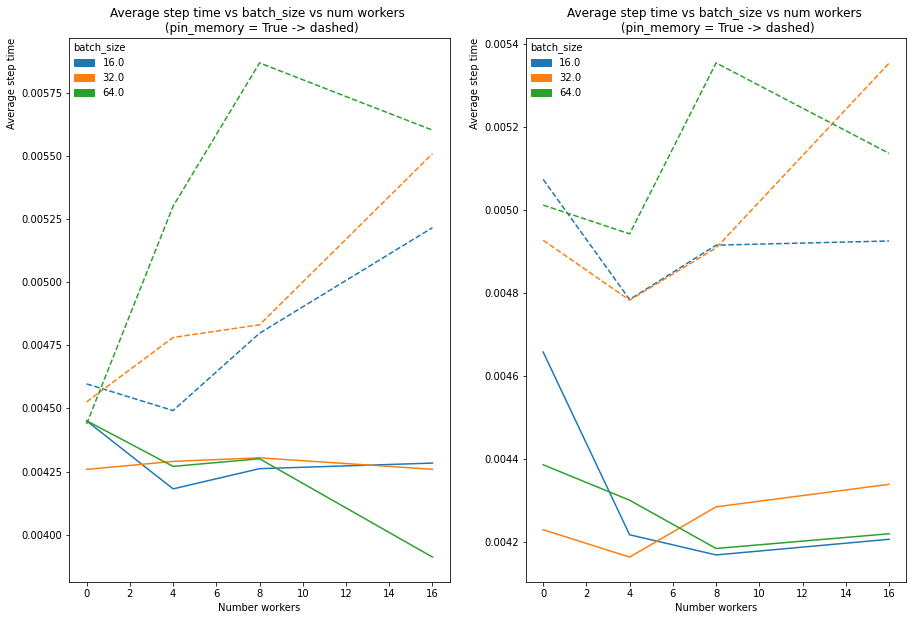

In [17]:
plot_data([data_s3_async, data_s3_threaded], "num_fetch_workers", 4, "batch_size", batch_size_unique)
# LEFT: Asyncio, RIGHT: Threaded

With smaller batches, and more workers, Asynio implementation provides the best average step time. What is interesting, from 0 to 8 workers it doesn't make a big difference, also for 16 and 32 workers. However, with 16 workers and batch size 64 it seems to be be the best.
In threaded implementation, number of workers matters more, and the sweet spot seems to be around 8, with larger batch size of 16 and 64. For batch size 32 the behavior seems to be a bit unexpected. 

In the following plots, we change the batch sizes to 16, 32 and 64, while on the each plot we show how different number of fetch workers, along with different number of workers influences the average step time.

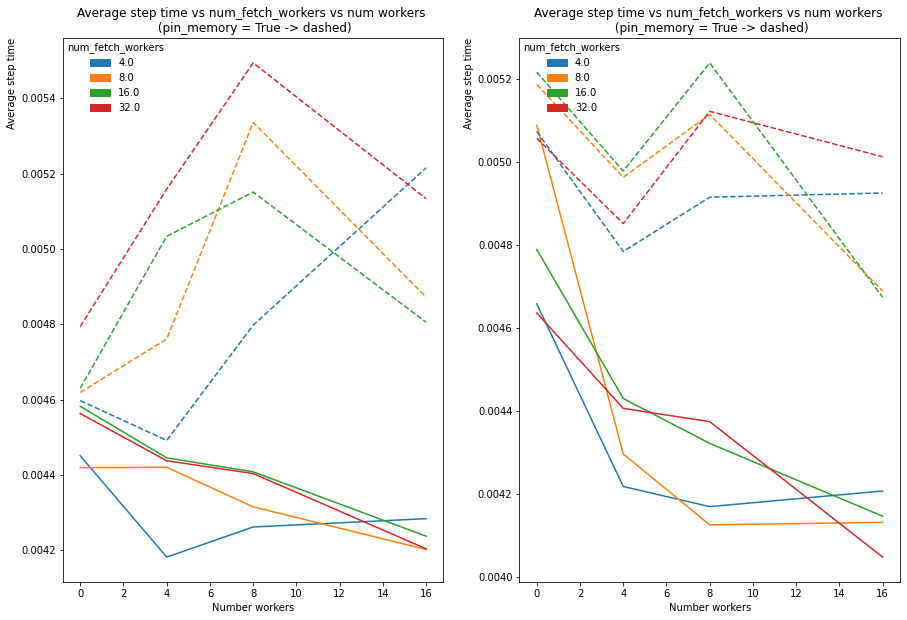

In [18]:
plot_data([data_s3_async, data_s3_threaded], "batch_size", 16, "num_fetch_workers", num_fetch_workers_unique)

Increasing number of fetch workers, also works better when the number of workers is increased. 
Best performance seem to be when number of workers matches number of fetch workers. At least this is for asyncio, however with threaded implementation, again, number of workers initially matters a lot, and regardles of the fetch workers, average step time is better with more workers. Best choice seems to be 32 fetch workers with 16 workers. 

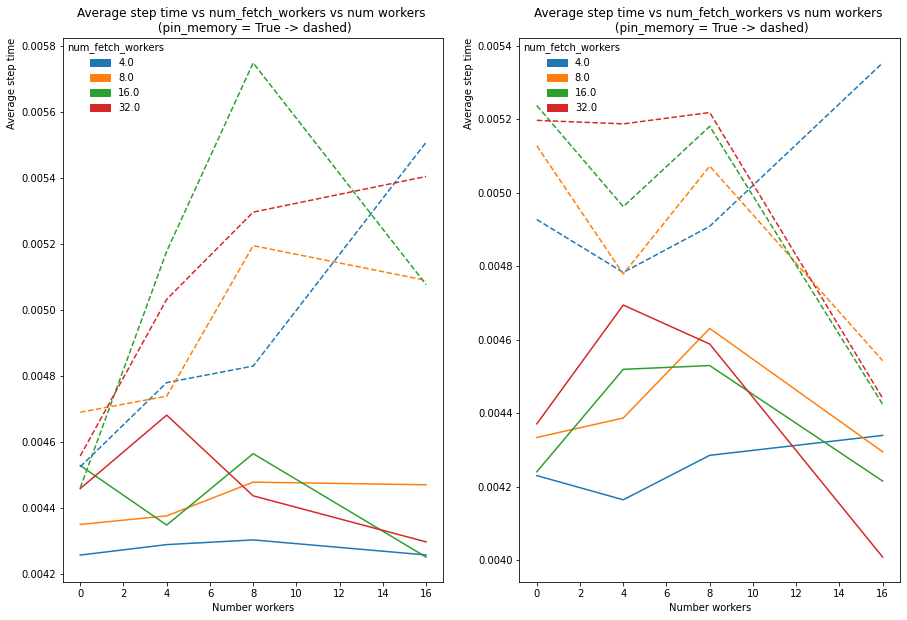

In [19]:
plot_data([data_s3_async, data_s3_threaded], "batch_size", 32, "num_fetch_workers", num_fetch_workers_unique)

With a higher batch size, it seems that Asyncio implementation doesn't change much with different number of fetch workers and workers. For example 4 fetch workers produces similar results regardless of the batch size. However with slightly bigger number of fetch workers (green, red i.e. 16 and 32), more workers is better. 
This indicates that with a lot of workers, we should also have a lot of fetch workers. However differences are very small.
Similarly, for threaded implementation with more workers, we need to increase number of fetch workers to get better performance. 

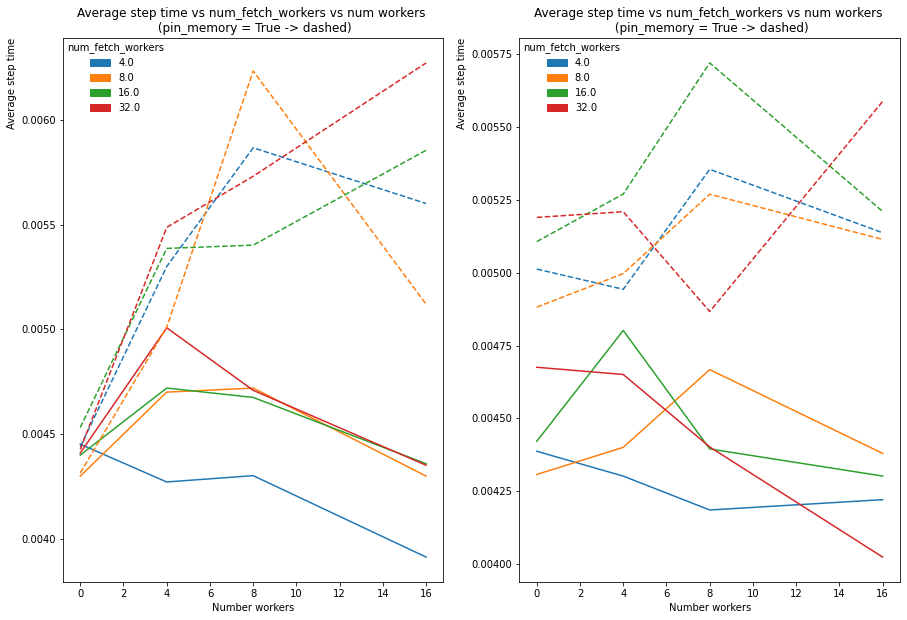

In [20]:
plot_data([data_s3_async, data_s3_threaded], "batch_size", 64, "num_fetch_workers", num_fetch_workers_unique)

With increasing the batch size, it seems that with both implementation more workers with more fetch workers seems to work better. However, it seems that in some cases low number of fetch workers (e.g. blue) with a lot of workers isn't a good choice.

In [21]:
# For later comparison with Scratch
s3_pin_async = data_s3_async[data_s3_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
s3_unpin_async = data_s3_async[data_s3_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
s3_pin_threaded = data_s3_threaded[data_s3_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
s3_unpin_threaded = data_s3_threaded[data_s3_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
# Cleanup
del data_s3_async
del data_s3_threaded

# Scratch storage <a class="anchor" id="scratchstorage">

In [22]:
df_dataloader_scratch_full = extract_pandas(output_base_folder, folder_filter="latest/e2e/*benchmark_e2e_scratch*")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15240/15240 [05:15<00:00, 48.36it/s]


In [23]:
df_dataloader_scratch_async=df_dataloader_scratch_full[df_dataloader_scratch_full["fetch_impl"]=="asyncio"]
df_dataloader_scratch_threaded=df_dataloader_scratch_full[df_dataloader_scratch_full["fetch_impl"]=="threaded"]
# save memory 
del df_dataloader_scratch_full
# show record num
print(f"Records {len(df_dataloader_scratch_async)}")
print(f"Records {len(df_dataloader_scratch_threaded)}")

Records 1891780
Records 2169650


In [24]:
display(get_run_stats(df_dataloader_scratch_async, group_by=group_by_dataloader))
display(get_run_stats(df_dataloader_scratch_threaded, group_by=group_by_dataloader))

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                       
scratch 4                 0           10         20211005f063246_benchmark_e2e_scratch_16_0_4_sync          1.374252e+09   
                                                 20211005f064536_benchmark_e2e_scratch_32_0_4_sync          1.377194e+09   
                                                 20211005f065810_benchmark_e2e_scratch_64_0_4_sync          1.392243e+09   
                                                 20211005f160318_benchmark_e2e_scratch_16_0_4_sync          1.374252e+09   
                                                 20211005f161509_benchmark_e2e_scratch_32_0_4_sync          1.377194e+09   
...                                                                                                                  ...   
        32                16          10         20211005f065702_benchmark_e2e_scratch_32_16_32_...         2.794107e+09   
                                                 20211005f070900_benchmark_e2e_scratch_64_16_32_...         2.838848e+09   
                                                 20211005f161421_benchmark_e2e_scratch_16_16_32_...         2.935798e+09   
                                                 20211005f162506_benchmark_e2e_scratch_32_16_32_...         3.026639e+09   
                                                 20211005f163514_benchmark_e2e_scratch_64_16_32_...         3.084292e+09   

                                                                                                       time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                                
scratch 4                 0           10         20211005f063246_benchmark_e2e_scratch_16_0_4_sync   1.633408e+09   
                                                 20211005f064536_benchmark_e2e_scratch_32_0_4_sync   1.633409e+09   
                                                 20211005f065810_benchmark_e2e_scratch_64_0_4_sync   1.633410e+09   
                                                 20211005f160318_benchmark_e2e_scratch_16_0_4_sync   1.633443e+09   
                                                 20211005f161509_benchmark_e2e_scratch_32_0_4_sync   1.633443e+09   
...                                                                                                           ...   
        32                16          10         20211005f065702_benchmark_e2e_scratch_32_16_32_...  1.633410e+09   
                                                 20211005f070900_benchmark_e2e_scratch_64_16_32_...  1.633411e+09   
                                                 20211005f161421_benchmark_e2e_scratch_16_16_32_...  1.633443e+09   
                                                 20211005f162506_benchmark_e2e_scratch_32_16_32_...  1.633444e+09   
                                                 20211005f163514_benchmark_e2e_scratch_64_16_32_...  1.633445e+09   

                                                                                                         time_end  \
dataset num_fetch_workers num_workers batch_pool run                                                                
scratch 4                 0           10         20211005f063246_benchmark_e2e_scratch_16_0_4_sync   1.633408e+09   
                                                 20211005f064536_benchmark_e2e_scratch_32_0_4_sync   1.633409e+09   
                                                 20211005f065810_benchmark_e2e_scratch_64_0_4_sync   1.633410e+09   
                                                 20211005f160318_benchmark_e2e_scratch_16_0_4_sync   1.633443e+09   
                                                 20211005f161509_benchmark_e2e_scratch_32_0_4_sync   1.633443e+09   
...                                                                                                           ...   
        32                16  

downloaded data [B]  \
dataset num_fetch_workers num_workers batch_pool run                                                                       
scratch 4                 0           10         20211005f020119_benchmark_e2e_scratch_16_0_4_sync          4.964656e+09   
                                                 20211005f021523_benchmark_e2e_scratch_32_0_4_sync          3.079109e+09   
                                                 20211005f022752_benchmark_e2e_scratch_64_0_4_sync          2.593969e+09   
                                                 20211005f113034_benchmark_e2e_scratch_16_0_4_sync          4.965359e+09   
                                                 20211005f114410_benchmark_e2e_scratch_32_0_4_sync          3.079109e+09   
...                                                                                                                  ...   
        32                16          10         20211005f022710_benchmark_e2e_scratch_32_16_32_...         2.956388e+09   
                                                 20211005f023737_benchmark_e2e_scratch_64_16_32_...         2.600274e+09   
                                                 20211005f114327_benchmark_e2e_scratch_16_16_32_...         4.435987e+09   
                                                 20211005f115539_benchmark_e2e_scratch_32_16_32_...         2.903786e+09   
                                                 20211005f120540_benchmark_e2e_scratch_64_16_32_...         2.600274e+09   

                                                                                                       time_start  \
dataset num_fetch_workers num_workers batch_pool run                                                                
scratch 4                 0           10         20211005f020119_benchmark_e2e_scratch_16_0_4_sync   1.633392e+09   
                                                 20211005f021523_benchmark_e2e_scratch_32_0_4_sync   1.633393e+09   
                                                 20211005f022752_benchmark_e2e_scratch_64_0_4_sync   1.633394e+09   
                                                 20211005f113034_benchmark_e2e_scratch_16_0_4_sync   1.633426e+09   
                                                 20211005f114410_benchmark_e2e_scratch_32_0_4_sync   1.633427e+09   
...                                                                                                           ...   
        32                16          10         20211005f022710_benchmark_e2e_scratch_32_16_32_...  1.633394e+09   
                                                 20211005f023737_benchmark_e2e_scratch_64_16_32_...  1.633394e+09   
                                                 20211005f114327_benchmark_e2e_scratch_16_16_32_...  1.633427e+09   
                                                 20211005f115539_benchmark_e2e_scratch_32_16_32_...  1.633428e+09   
                                                 20211005f120540_benchmark_e2e_scratch_64_16_32_...  1.633428e+09   

                                                                                                         time_end  \
dataset num_fetch_workers num_workers batch_pool run                                                                
scratch 4                 0           10         20211005f020119_benchmark_e2e_scratch_16_0_4_sync   1.633392e+09   
                                                 20211005f021523_benchmark_e2e_scratch_32_0_4_sync   1.633393e+09   
                                                 20211005f022752_benchmark_e2e_scratch_64_0_4_sync   1.633394e+09   
                                                 20211005f113034_benchmark_e2e_scratch_16_0_4_sync   1.633426e+09   
                                                 20211005f114410_benchmark_e2e_scratch_32_0_4_sync   1.633427e+09   
...                                                                                                           ...   
        32                16  

In [25]:
print(np.unique(df_dataloader_scratch_threaded["num_workers"].to_numpy()))
print(np.unique(df_dataloader_scratch_threaded["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_scratch_threaded["batch_size"].to_numpy()))


[ 0  4  8 16]
[ 4  8 16 32]
[16 32 64]


In [26]:
data_scratch_async = filter_data(df_dataloader_scratch_async)
data_scratch_threaded = filter_data(df_dataloader_scratch_threaded)
# del df_dataloader_scratch_async
# del df_dataloader_scratch_threaded

In [27]:
data_scratch_async.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
90,0.003846,0.003487,0.0,16.0,32.0,16.0,"16, 32, 16, 0"
48,0.003910,0.003726,0.0,8.0,4.0,16.0,"8, 4, 16, 0"
72,0.003928,0.003489,0.0,16.0,4.0,16.0,"16, 4, 16, 0"
84,0.004000,0.003732,0.0,16.0,16.0,16.0,"16, 16, 16, 0"
78,0.004017,0.003647,0.0,16.0,8.0,16.0,"16, 8, 16, 0"
...,...,...,...,...,...,...,...
47,0.007288,0.004918,1.0,4.0,32.0,64.0,"4, 32, 64, 1"
71,0.007386,0.003949,1.0,8.0,32.0,64.0,"8, 32, 64, 1"
35,0.007511,0.004165,1.0,4.0,8.0,64.0,"4, 8, 64, 1"
29,0.007664,0.004250,1.0,4.0,4.0,64.0,"4, 4, 64, 1"


In [28]:
data_scratch_threaded.sort_values(["mean"], ascending=True)

,mean,median,pin_memory,num_workers,num_fetch_workers,batch_size,config
80,0.003463,0.002917,0.0,16.0,8.0,32.0,"16, 8, 32, 0"
88,0.003492,0.003109,0.0,16.0,16.0,64.0,"16, 16, 64, 0"
94,0.003543,0.003080,0.0,16.0,32.0,64.0,"16, 32, 64, 0"
74,0.003546,0.003136,0.0,16.0,4.0,32.0,"16, 4, 32, 0"
86,0.003653,0.003229,0.0,16.0,16.0,32.0,"16, 16, 32, 0"
...,...,...,...,...,...,...,...
71,0.005920,0.003889,1.0,8.0,32.0,64.0,"8, 32, 64, 1"
29,0.005933,0.004795,1.0,4.0,4.0,64.0,"4, 4, 64, 1"
41,0.006152,0.004635,1.0,4.0,16.0,64.0,"4, 16, 64, 1"
47,0.006253,0.004569,1.0,4.0,32.0,64.0,"4, 32, 64, 1"


**Memory pinning** <a class="anchor" id="scratchmempin">

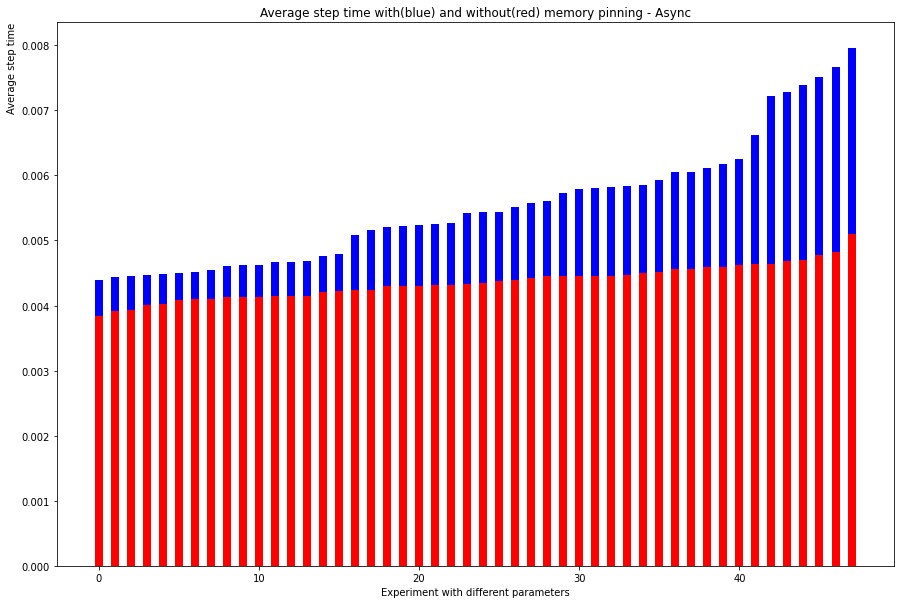

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))

data = data_scratch_async[data_scratch_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_scratch_async[data_scratch_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

      
ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Async", loc='center')

del data


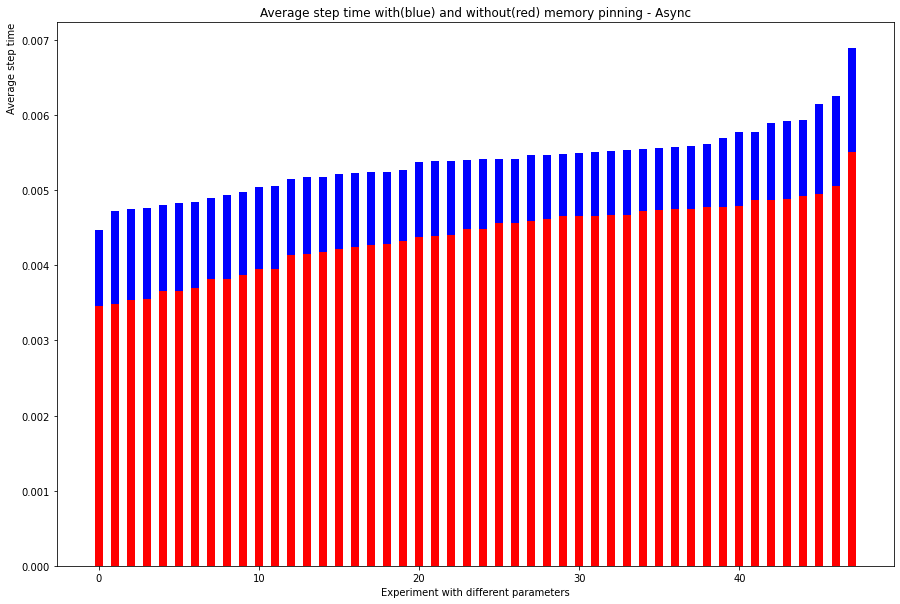

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_scratch_threaded[data_scratch_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_scratch_threaded[data_scratch_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step time with(blue) and without(red) memory pinning - Async", loc='center')
del data

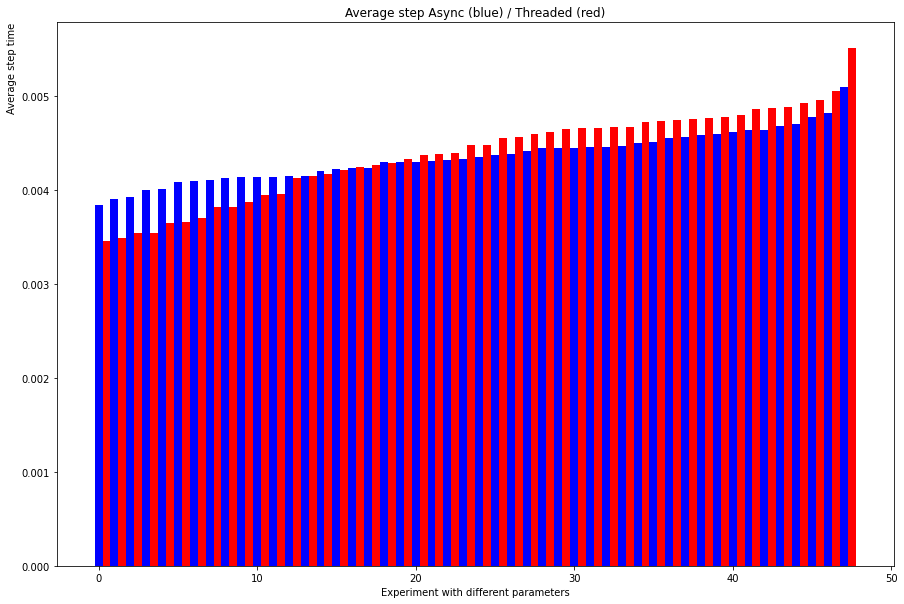

In [48]:
fig, ax = plt.subplots(figsize=(15, 10))
data = data_scratch_async[data_scratch_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=range(len(data)), height=data["mean"], width=0.5, color="blue")
data = data_scratch_threaded[data_scratch_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)
ax.bar(x=[x+0.5 for x in range(len(data))], height=data["mean"], width=0.5, color="red")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Average step Async (blue) / Threaded (red)", loc='center')
del data

### Asyncio vs Threaded for Scratch <a class="anchor" id="scratchasynciovsthreaded">

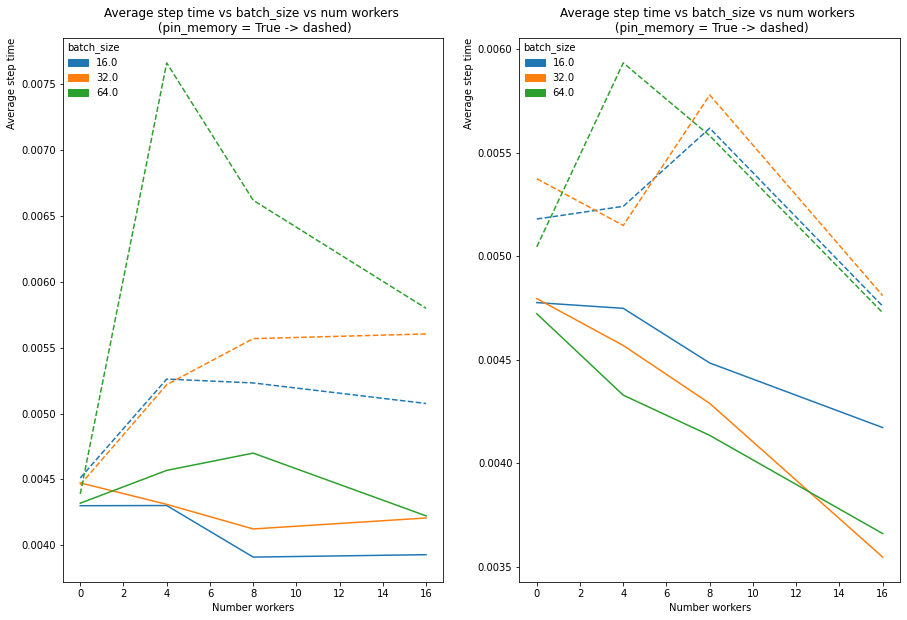

In [32]:
plot_data([data_scratch_async, data_scratch_threaded], "num_fetch_workers", 4, "batch_size", batch_size_unique)

Again, it seems that with more workers we get better results, however for Asyncio implementation batch size should be kept rather smaller, though batch size doesn't have such a big influence as for Threaded implementation. For threaded appraoch differences are bigger, and again, biggest batch doesn't produce best results.

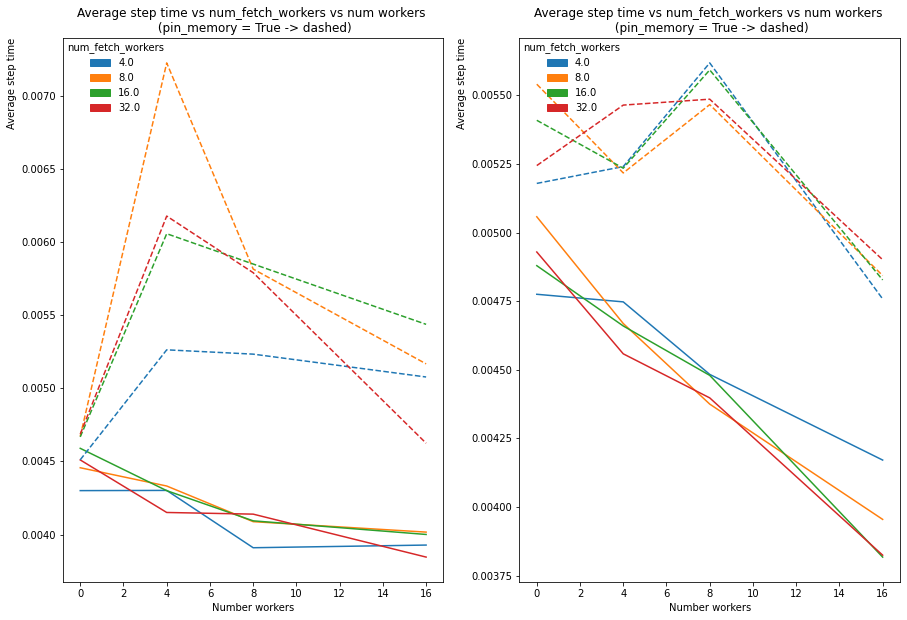

In [33]:
plot_data([data_scratch_async, data_scratch_threaded], "batch_size", 16, "num_fetch_workers", num_fetch_workers_unique)

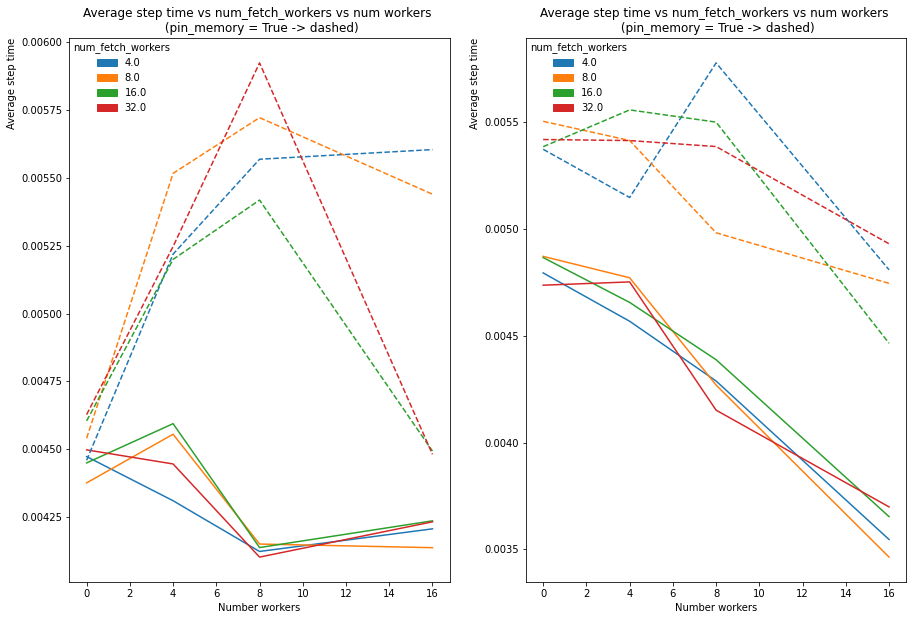

In [34]:
plot_data([data_scratch_async, data_scratch_threaded], "batch_size", 32, "num_fetch_workers", num_fetch_workers_unique)

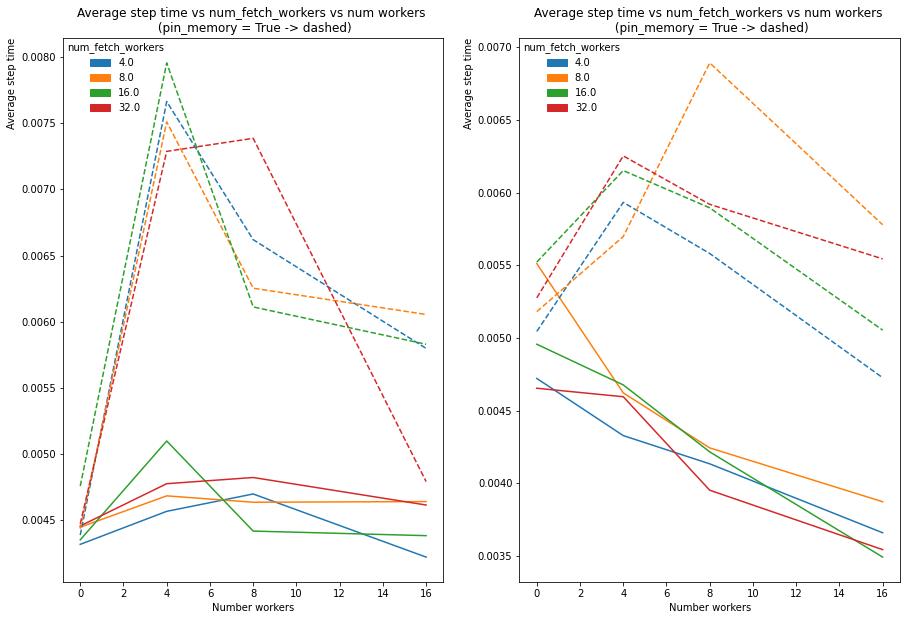

In [35]:
plot_data([data_scratch_async, data_scratch_threaded], "batch_size", 64, "num_fetch_workers", num_fetch_workers_unique)

In the async implementation icreasing the batch size doesn't always produce the best result. In both implementations, batch size 16 seems to be the best. While, the relationship with fetch workers and workers doesn't seem to produce largely different results, i.e. does't have much influence. 
Furthermore, for threaded implementation, we notice that with higher batches, we should also increase the number of workers and fetch workers. 

### S3 vs Scratch - mean step time  <a class="anchor" id="s3vsscratch">

Text(0.5, 1.0, 'Async: pinned (scratch - blue, s3 - green), unpinned (scratch - red, s3 - pink)')

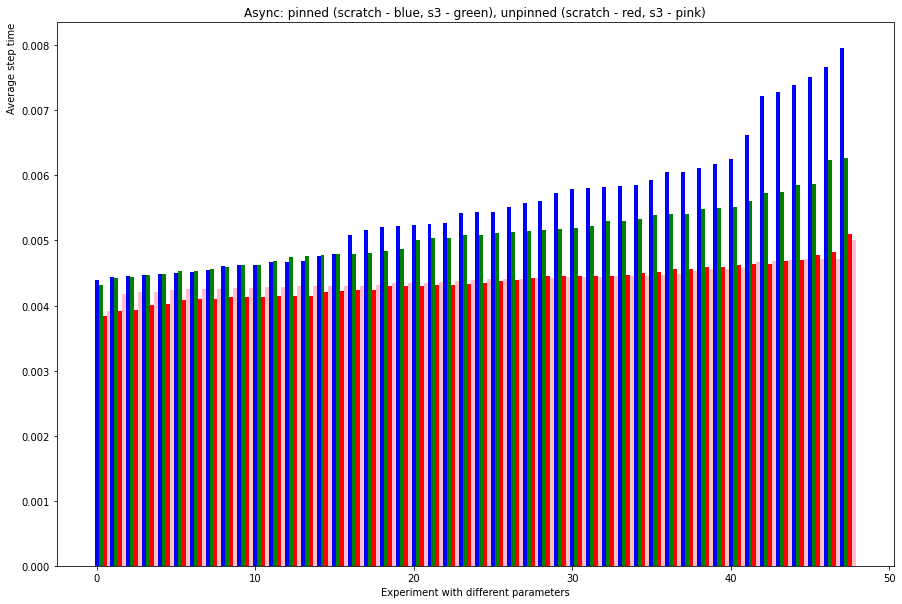

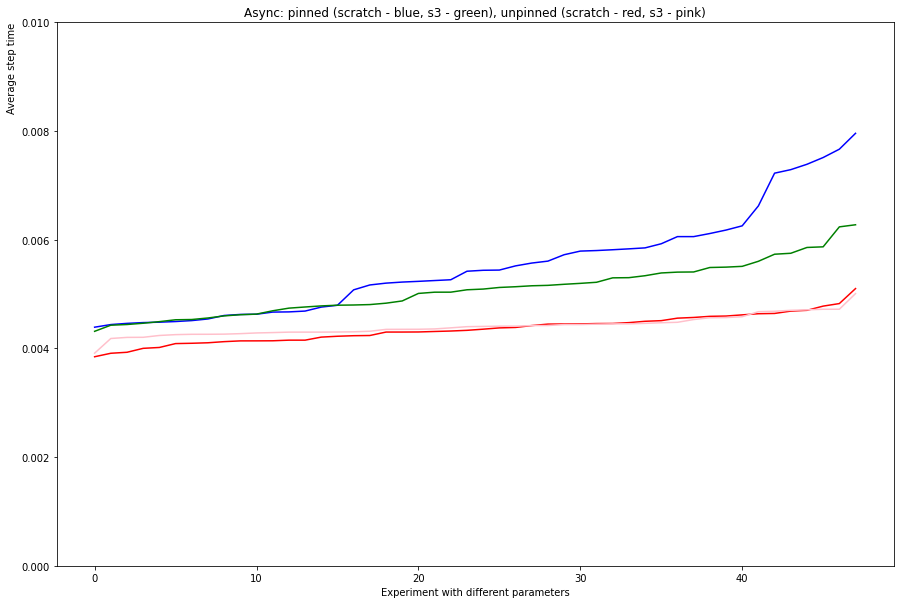

In [52]:
scratch_pin_async = data_scratch_async[data_scratch_async["pin_memory"]==1].sort_values(["mean"], ascending=True)
scratch_unpin_async = data_scratch_async[data_scratch_async["pin_memory"]==0].sort_values(["mean"], ascending=True)
scratch_pin_threaded = data_scratch_threaded[data_scratch_threaded["pin_memory"]==1].sort_values(["mean"], ascending=True)
scratch_unpin_threaded = data_scratch_threaded[data_scratch_threaded["pin_memory"]==0].sort_values(["mean"], ascending=True)

# async
w = 1.0/4.0
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(x=range(len(scratch_pin_async)), height=scratch_pin_async["mean"], width=w, color="blue")
ax.bar(x=[x+0.25 for x in range(len(s3_pin_async))], height=s3_pin_async["mean"], width=w, color="green")
ax.bar(x=[x+0.5 for x in range(len(scratch_unpin_async))], height=scratch_unpin_async["mean"], width=w, color="red")
ax.bar(x=[x+0.75 for x in range(len(s3_unpin_async))], height=s3_unpin_async["mean"], width=w, color="pink")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Async: pinned (scratch - blue, s3 - green), unpinned (scratch - red, s3 - pink)", loc='center')

fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.0, ymax=0.01)
ax.plot(range(len(scratch_pin_async)), scratch_pin_async["mean"], color="blue")
ax.plot(range(len(scratch_pin_async)), s3_pin_async["mean"], color="green")
ax.plot(range(len(scratch_pin_async)), scratch_unpin_async["mean"], color="red")
ax.plot(range(len(scratch_pin_async)), s3_unpin_async["mean"], color="pink")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Async: pinned (scratch - blue, s3 - green), unpinned (scratch - red, s3 - pink)", loc='center')


Text(0.5, 1.0, 'Threaded: pinned (scratch - blue, s3 - green), unpinned (scratch - red, s3 - pink)')

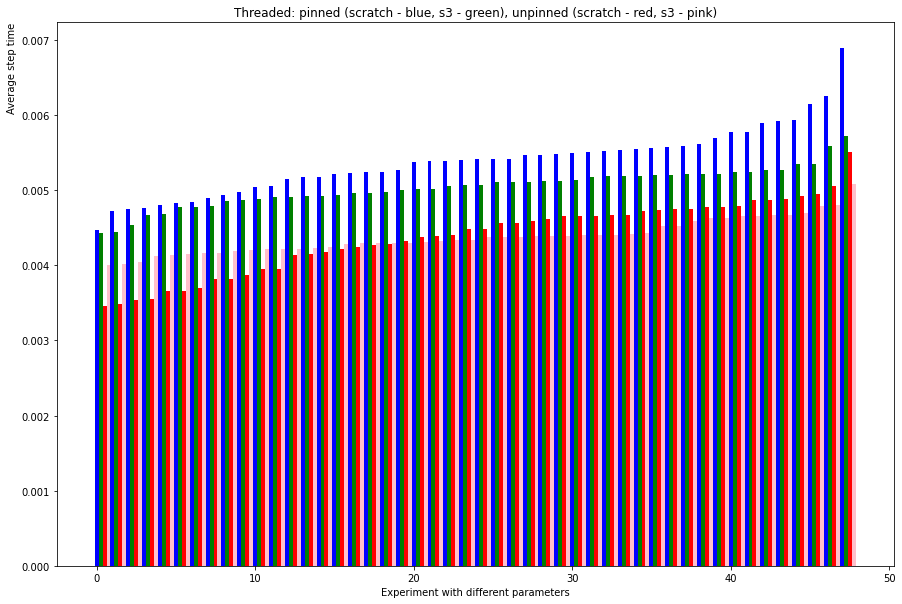

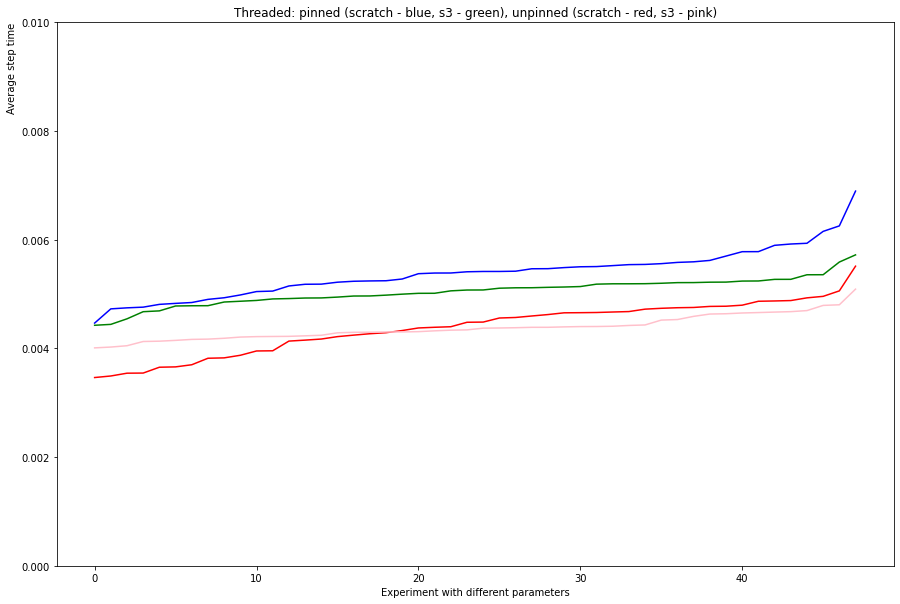

In [53]:
# threaded
w = 1.0/4.0
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(x=range(len(scratch_pin_threaded)), height=scratch_pin_threaded["mean"], width=w, color="blue")
ax.bar(x=[x+0.25 for x in range(len(s3_pin_threaded))], height=s3_pin_threaded["mean"], width=w, color="green")
ax.bar(x=[x+0.5 for x in range(len(scratch_unpin_threaded))], height=scratch_unpin_threaded["mean"], width=w, color="red")
ax.bar(x=[x+0.75 for x in range(len(s3_unpin_threaded))], height=s3_unpin_threaded["mean"], width=w, color="pink")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Threaded: pinned (scratch - blue, s3 - green), unpinned (scratch - red, s3 - pink)", loc='center')

fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.0, ymax=0.01)
ax.plot(range(len(scratch_pin_threaded)), scratch_pin_threaded["mean"], color="blue")
ax.plot(range(len(scratch_pin_threaded)), s3_pin_threaded["mean"], color="green")
ax.plot(range(len(scratch_pin_threaded)), scratch_unpin_threaded["mean"], color="red")
ax.plot(range(len(scratch_pin_threaded)), s3_unpin_threaded["mean"], color="pink")

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"Threaded: pinned (scratch - blue, s3 - green), unpinned (scratch - red, s3 - pink)", loc='center')



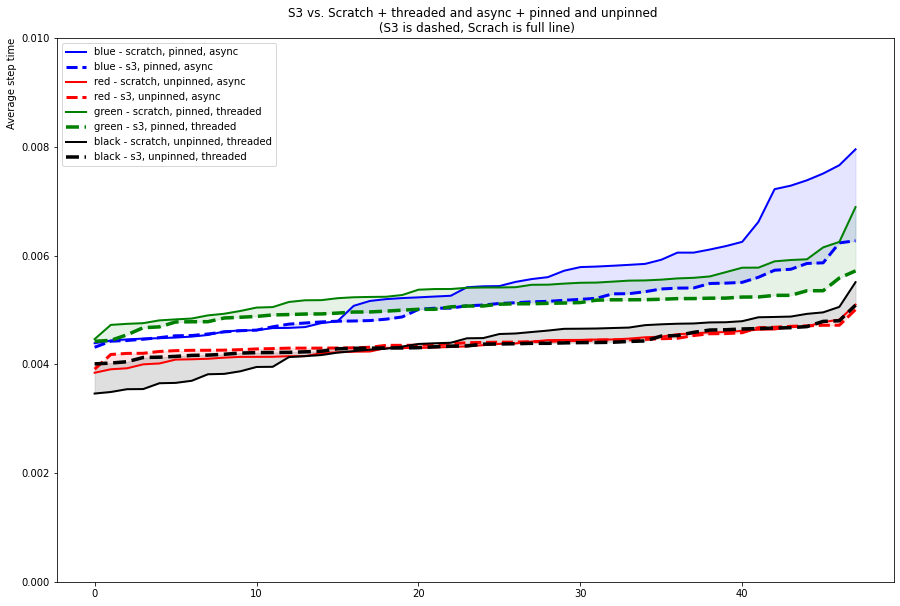

In [524]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.0, ymax=0.01)
l1 = ax.plot(range(len(scratch_pin_async)), scratch_pin_async["mean"], color="blue", linewidth=2, label="blue - scratch, pinned, async")
l2 = ax.plot(range(len(scratch_pin_async)), s3_pin_async["mean"], color="blue", linewidth=3, linestyle="--", label="blue - s3, pinned, async")
l3 = ax.plot(range(len(scratch_pin_async)), scratch_unpin_async["mean"], color="red", linewidth=2, label="red - scratch, unpinned, async")
l4 = ax.plot(range(len(scratch_pin_async)), s3_unpin_async["mean"], color="red", linewidth=3, linestyle="--", label="red - s3, unpinned, async")
l5 = ax.plot(range(len(scratch_pin_threaded)), scratch_pin_threaded["mean"], color="green", linewidth=2, label="green - scratch, pinned, threaded")
l6 = ax.plot(range(len(scratch_pin_threaded)), s3_pin_threaded["mean"], color="green", linewidth=3.5, linestyle="--", label="green - s3, pinned, threaded")
l7 = ax.plot(range(len(scratch_pin_threaded)), scratch_unpin_threaded["mean"], color="black", linewidth=2, label="black - scratch, unpinned, threaded")
l8 = ax.plot(range(len(scratch_pin_threaded)), s3_unpin_threaded["mean"], color="black", linestyle="--", linewidth=3.5, label="black - s3, unpinned, threaded")

ax.fill_between(range(len(scratch_pin_async)),scratch_pin_async["mean"], s3_pin_async["mean"], color="blue", alpha=0.1)
ax.fill_between(range(len(scratch_pin_async)),scratch_unpin_async["mean"], s3_unpin_async["mean"], color="red", alpha=0.1)
ax.fill_between(range(len(scratch_pin_async)),scratch_pin_threaded["mean"], s3_pin_threaded["mean"], color="green", alpha=0.1)
ax.fill_between(range(len(scratch_pin_async)),scratch_unpin_threaded["mean"], s3_unpin_threaded["mean"], color="gray", alpha=0.25)


# ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"S3 vs. Scratch + threaded and async + pinned and unpinned \n (S3 is dashed, Scrach is full line)", loc='center')
ax.legend()

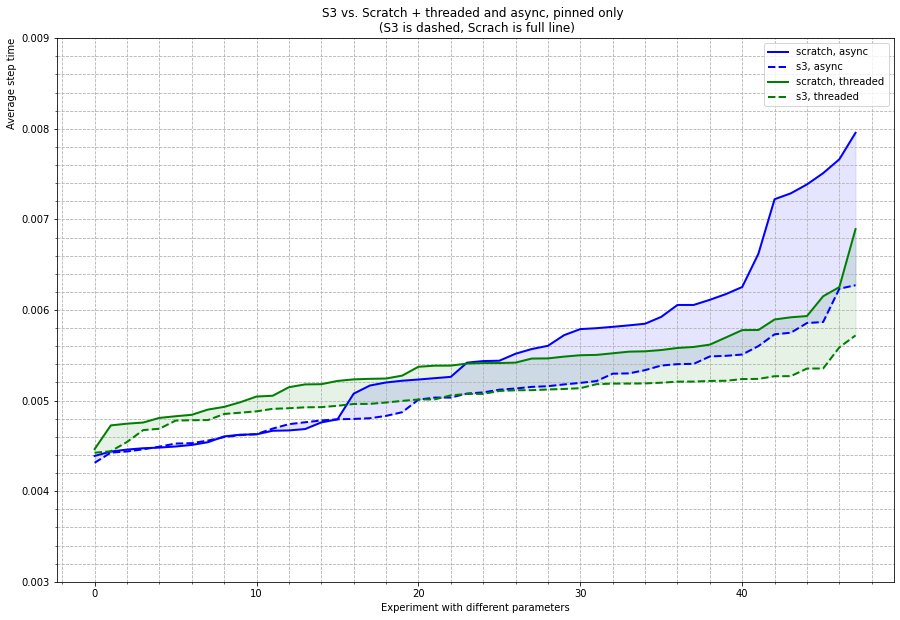

In [525]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.003, ymax=0.009)
ax.minorticks_on()
ax.plot(range(len(scratch_pin_async)), scratch_pin_async["mean"], color="blue", linewidth=2, label="scratch, async")
ax.plot(range(len(scratch_pin_async)), s3_pin_async["mean"],  linestyle="--", color="blue", linewidth=2, label="s3, async")
ax.plot(range(len(scratch_pin_threaded)), scratch_pin_threaded["mean"], color="green", linewidth=2, label="scratch, threaded")
ax.plot(range(len(scratch_pin_threaded)), s3_pin_threaded["mean"], linestyle="--", color="green", linewidth=2, label="s3, threaded")
ax.grid(linestyle='--', which="both")

ax.fill_between(range(len(scratch_pin_async)),scratch_pin_async["mean"], s3_pin_async["mean"], color="blue", alpha=0.1)
ax.fill_between(range(len(scratch_pin_async)),scratch_pin_threaded["mean"], s3_pin_threaded["mean"], color="green", alpha=0.1)

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"S3 vs. Scratch + threaded and async, pinned only \n (S3 is dashed, Scrach is full line)", loc='center')
ax.legend()

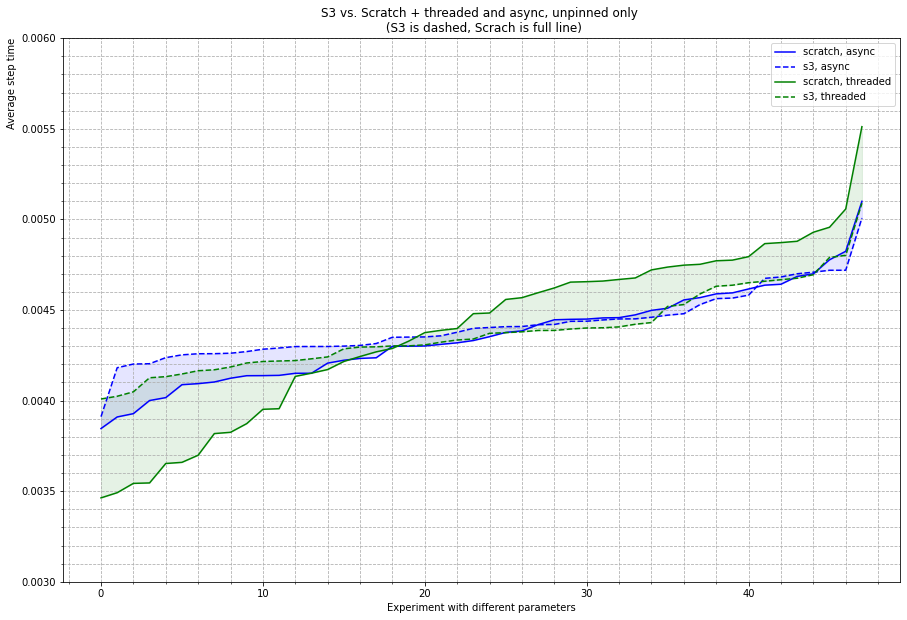

In [153]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.003, ymax=0.006)
ax.minorticks_on()
ax.plot(range(len(scratch_pin_async)), scratch_unpin_async["mean"], color="blue", label="scratch, async")
ax.plot(range(len(scratch_pin_async)), s3_unpin_async["mean"], color="blue", linestyle="--", label="s3, async")
ax.plot(range(len(scratch_pin_threaded)), scratch_unpin_threaded["mean"], color="green", label="scratch, threaded")
ax.plot(range(len(scratch_pin_threaded)), s3_unpin_threaded["mean"], color="green", linestyle="--", label="s3, threaded")
ax.grid(linestyle='--', which="both")

ax.fill_between(range(len(scratch_pin_async)),scratch_unpin_async["mean"], s3_unpin_async["mean"], color="blue", alpha=0.1)
ax.fill_between(range(len(scratch_pin_async)),scratch_unpin_threaded["mean"], s3_unpin_threaded["mean"], color="green", alpha=0.1)

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Average step time", loc="top")
ax.set_title(f"S3 vs. Scratch + threaded and async, unpinned only \n (S3 is dashed, Scrach is full line)", loc='center')
ax.legend()

##### Median time? 

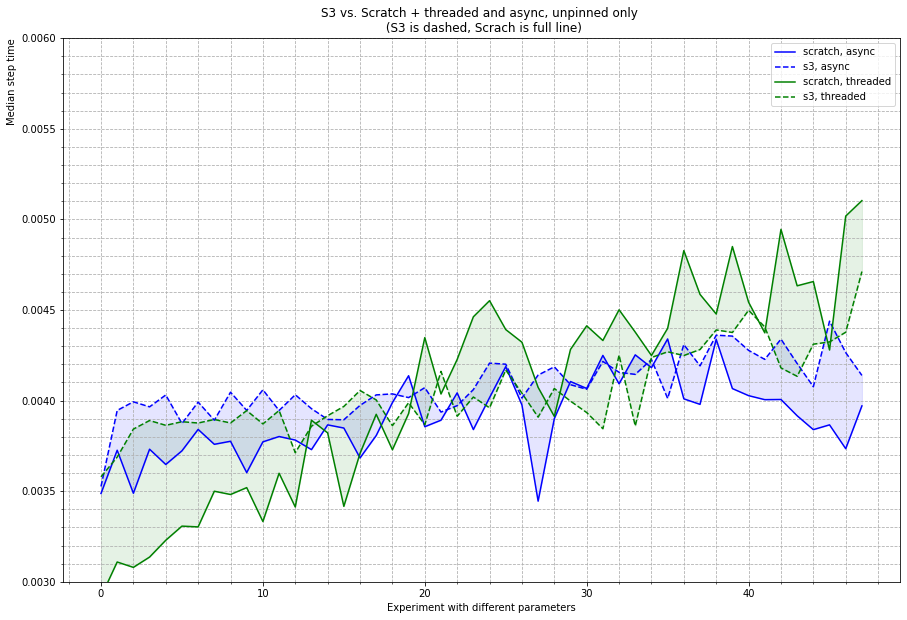

In [158]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis(ymin=0.003, ymax=0.006)
ax.minorticks_on()
ax.plot(range(len(scratch_pin_async)), scratch_unpin_async["median"], color="blue", label="scratch, async")
ax.plot(range(len(scratch_pin_async)), s3_unpin_async["median"], color="blue", linestyle="--", label="s3, async")
ax.plot(range(len(scratch_pin_threaded)), scratch_unpin_threaded["median"], color="green", label="scratch, threaded")
ax.plot(range(len(scratch_pin_threaded)), s3_unpin_threaded["median"], color="green", linestyle="--", label="s3, threaded")
ax.grid(linestyle='--', which="both")

ax.fill_between(range(len(scratch_pin_async)),scratch_unpin_async["median"], s3_unpin_async["median"], color="blue", alpha=0.1)
ax.fill_between(range(len(scratch_pin_async)),scratch_unpin_threaded["median"], s3_unpin_threaded["median"], color="green", alpha=0.1)

ax.set_xlabel("Experiment with different parameters", loc="center")
ax.set_ylabel("Median step time", loc="top")
ax.set_title(f"S3 vs. Scratch + threaded and async, unpinned only \n (S3 is dashed, Scrach is full line)", loc='center')
ax.legend()

In order to perform well, we want S3 dashed lines to be above Scratch lines. 

We find that with some combinations we can get slightly better performance.

In [126]:
df_joined = pd.concat([s3_unpin_async[["mean", "config"]], 
                       s3_unpin_threaded[["mean", "config"]], 
                       scratch_unpin_async[["mean", "config"]], 
                       scratch_unpin_threaded[["mean", "config"]]], axis=1)
df_joined.reset_index(drop=True, inplace=True)

df_joined['diff_as'] = df_joined.apply(lambda row: float(row[4] - row[0]) , axis = 1)
df_joined['diff_thr'] = df_joined.apply(lambda row: float(row[6] - row[2]) , axis = 1)
df_joined = df_joined.set_axis(["s3_as_m", 
                                "s3_as_m_cfg", 
                                "s3_thr_m", 
                                "s3_thr_m_cfg",
                                "sc_as_m", 
                                "sc_as_m_cfg", 
                                "sc_thr_m", 
                                "sc_thr_m_cfg", 
                                "diff_as",
                                "diff_thr"], axis=1, inplace=False)
df_joined = df_joined.sort_values(["sc_as_m"], ascending=True)

**When is S3 better?**
Config order: `{num_workers}, {num_fetch_workers}, {batch_size}, {pin_memory}`

In [154]:
print(df_joined.sort_values(["diff_as"], ascending=False)[["s3_as_m", "s3_as_m_cfg", "sc_as_m", "sc_as_m_cfg", "diff_as"]].head())

     s3_as_m   s3_as_m_cfg   sc_as_m   sc_as_m_cfg   diff_as
26  0.004301   8, 4, 64, 0  0.004700   8, 4, 64, 0  0.000399
20  0.004719  4, 16, 64, 0  0.005100  4, 16, 64, 0  0.000380
41  0.004299  16, 8, 64, 0  0.004642  16, 8, 64, 0  0.000343
38  0.003911  16, 4, 64, 0  0.004223  16, 4, 64, 0  0.000311
14  0.004271   4, 4, 64, 0  0.004568   4, 4, 64, 0  0.000298


In [155]:
print(df_joined.sort_values(["diff_thr"], ascending=False)[["s3_thr_m", "s3_thr_m_cfg", "sc_thr_m", "sc_thr_m_cfg", "diff_thr"]].head())

   s3_thr_m  s3_thr_m_cfg  sc_thr_m  sc_thr_m_cfg  diff_thr
5  0.004308   0, 8, 64, 0  0.005512   0, 8, 64, 0  0.001204
7  0.004241  0, 16, 32, 0  0.004866  0, 16, 32, 0  0.000625
1  0.004231   0, 4, 32, 0  0.004794   0, 4, 32, 0  0.000564
4  0.004334   0, 8, 32, 0  0.004872   0, 8, 32, 0  0.000537
8  0.004421  0, 16, 64, 0  0.004957  0, 16, 64, 0  0.000535


In [519]:
def plot_performance(dfs3, dfscr, alternate, name_fix, value_fix, name, anotate_coords=None):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.axis(ymin=0.003, ymax=0.006)
    for i, (batch_size, color) in enumerate(zip([16, 32, 64], ["red", "lime", "aqua"])):
        s3_fix = dfs3[(dfs3[name_fix]==value_fix) * 
                                (dfs3["batch_size"]==batch_size)]
        scratch_fix = dfscr[(dfscr[name_fix]==value_fix) & 
                            (dfscr["batch_size"]==batch_size)]
        s3_fix = s3_fix.sort_values([alternate], ascending=True)
        scratch_fix = scratch_fix.sort_values([alternate], ascending=True)
        if i == 0:
            xrange = scratch_fix[alternate] - 1
        else:
            xrange = scratch_fix[alternate] + i - 1
        ax.bar(x=xrange, height=scratch_fix["mean"], width=0.25, color=color, label=f"Scr. batch size {batch_size}")
        ax.bar(x=xrange+0.4, height=s3_fix["mean"], hatch="xxx", color=color, width=0.25, label=f"S3 batch size {batch_size}")
    ax.grid(linestyle='--', which="both")
    ax.set_xticks(scratch_fix[alternate])

    if anotate_coords is not None:
        for coords in anotate_coords:
            ax.annotate("", xy=(coords[0], coords[1]), 
                        xytext=(coords[0], coords[1]+0.0003), arrowprops=dict(arrowstyle="->"))    

            ax.set_xlabel(f"{alternate}", loc="center")
    ax.set_ylabel("Mean step time", loc="top")
    ax.set_title(f"{name}: When is accessing S3 better than Scratch? - highlighted area. {name_fix} = {value_fix}", loc='center')
    ax.legend()

**Pinned - async (S3 vs scratch)** -- different fetcher number

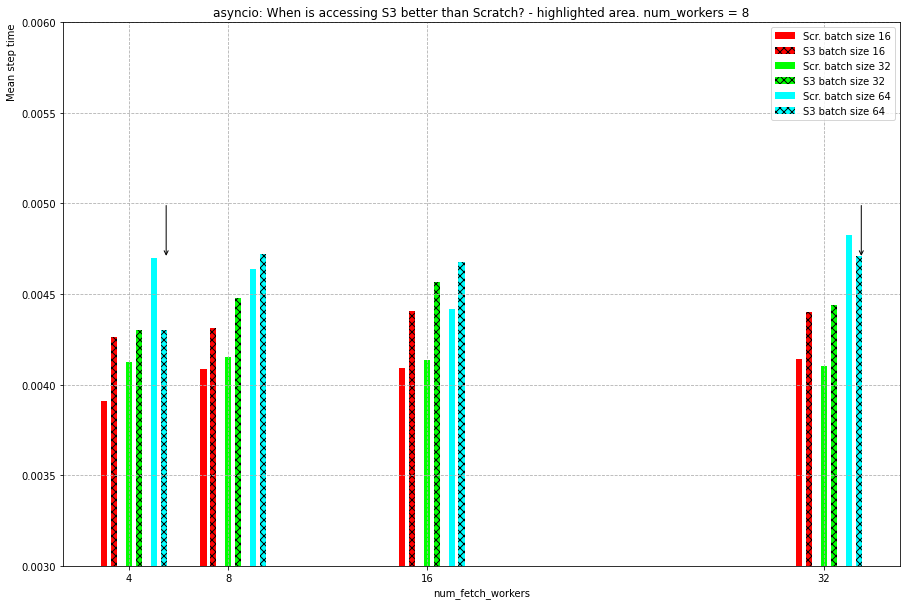

In [520]:
plot_performance(s3_unpin_async, scratch_unpin_async, "num_fetch_workers", "num_workers", 8, "asyncio", 
                 anotate_coords=[[5.5, 0.0047],[33.5, 0.0047]])

**Pinned - async (S3 vs scratch)** -- different worker number

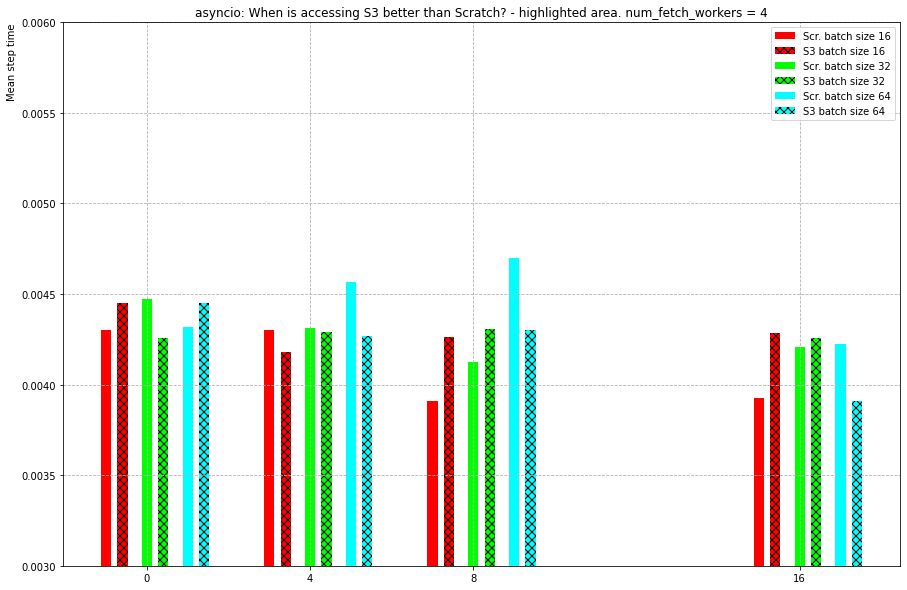

In [516]:
plot_performance(s3_unpin_async, scratch_unpin_async, "num_workers", "num_fetch_workers", 4, "asyncio")

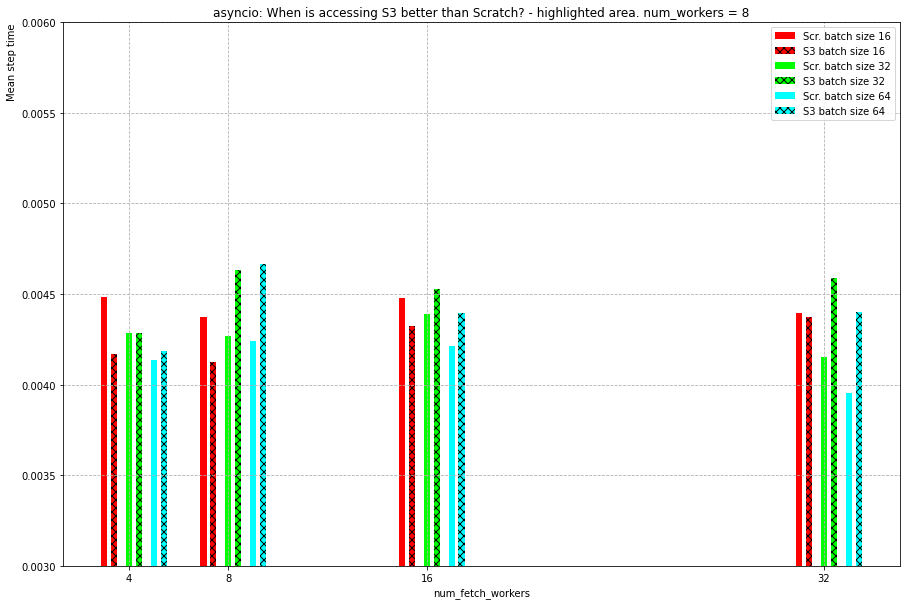

In [417]:
plot_performance(s3_unpin_threaded, scratch_unpin_threaded, "num_fetch_workers", "num_workers", 8, "asyncio")

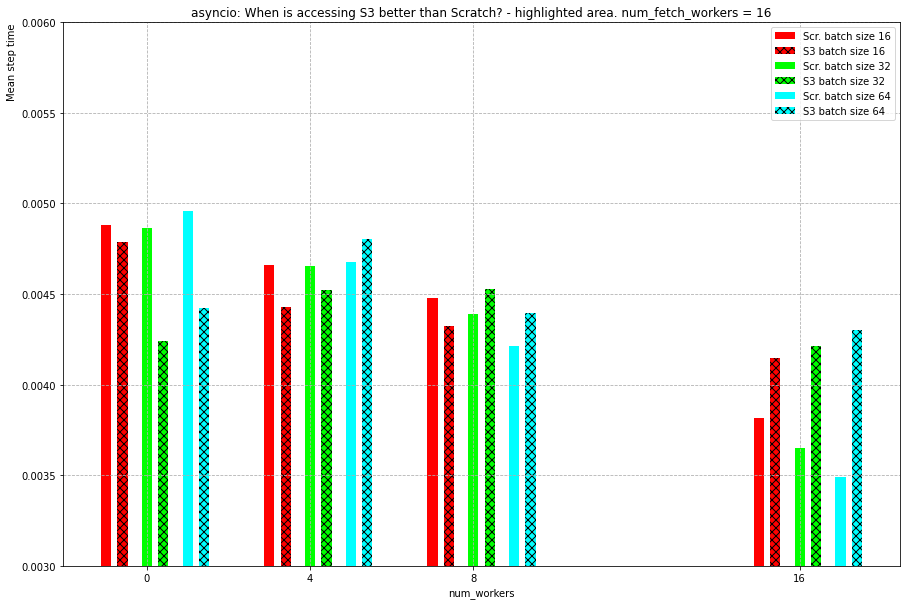

In [418]:
plot_performance(s3_unpin_threaded, scratch_unpin_threaded, "num_workers", "num_fetch_workers", 16, "asyncio")

Example where Scratch is better

Concluding remarks:

 - Memory pinning:
   - unpinned memory produces better end-2-end results w.r.t. average step duration for both S3 and Scratch, with both `Threaded` and `asyncio` implementation. It is shown as shown [here for S3](#s3mempin), and [here for scratch](#scratchmempin). 
     - the charts are ordered by growing average step time, without particular meaning to the X axis. It represents a single experiment. 
   - having the question, when can S3 storage access be better than Scratch, or at least, when can we come close, **we can ignore memory pinning for now**. That said,  for both [S3](#s3mempin) `threaded` and `asyncio` implementations are comparable. However, with and [scratch](#scratchmempin) it seems that there are occasions in which both have advantages, depending on remaining parameters (batch size, number of workers and number of fetchers)
 - S3 access  
   - increasing the number of workers, while the number of fetchers is fixed at 4, with `asyncio` more workers seem to work better with bigger batch. The same can be observed wth threaded implementation.
   - with fixed batch size at 16, with `async` implementation more fetchers with more workers improves the result. This is even more evident for `threaded` implementation, where the small number of fetchers seems to be a bad choice with a bigger number of workers. With 16 workers, the best fetcher choice seem to be 32 and 16 for both implementations, while with 4 there is a trend of lowering the performance. Increasing the batch size, the observation is the same. However, for 4 and 8 workers, the results seem to be worese that with 1 worker. This might be to overhead of mananiging more threads. 
   - a rule of thumb points that **number of fetch workers should be at least half the number of workers**
 - Scratch access
   - increasing the number of workers, with fetchers fixed at 4, clearly shows that with `asyncio` smaller batches are a better choice, while with threaded implementation, mid to bigger batches work better. Though in general with more workers bigger batch size seems to be better. **Batch size should be double the number of workers, and for `threaded` would be even better**
   - furthermore with batch fixed at 16, with `asyncio` increasing the number of workers and fetchers produces best and comparable results. The same is for the `threaded` implementation. Now, with increasing the number of batches to 32 with `asyncio` the sweetspot seems to be 8 workers with any number of fetchers >4, and for batch 64, 4 and 16 fetchers with 16 workers seems to be the best choice. With threaded implementation, in general more workers works better with more fetchers. In general, average step time for asyncio is better with smaller batches, while for threaded approach bigger batches are a better choice. 
 - S3 vs. Scratch
  - For asyncio, increasing the batch size, increases the mean step time, however, and number of workers fetchers with 8 workers, we get compareable results.
For threaded smaller batches with less workers seems to be the best due to networking overheads?
 
Todo: 
 - throughput for items and batches
 - what batch size produces comparable results between S3 and Scratch (also change prefetch size?)
   - alternate batch size, keep number of fetchers and workers
 